In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import imghdr
import random
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

drive.mount('/content/drive')

<ipython-input-1-745d3056bb79>:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Mounted at /content/drive


In [2]:
# Define image path
#  Hugo's Data Path
# base_dir = "/content/drive/MyDrive/Colab Notebooks/Images DLGA"
# output_dir = "/content/drive/MyDrive/Colab Notebooks/dataset"
# output_json = "/content/drive/MyDrive/Colab Notebooks/labels.json"

# Anita's Data Path
base_dir = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/Images DLGA"
output_dir = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/dataset"
output_json = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/labels.json"

In [3]:
# Create a dictionary to store image-class mappings
image_class_dict = {}

# Iterate through each class (subfolder)
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):  # Ensure it's a directory
        for img in os.listdir(cls_path):
            image_class_dict[img] = cls  # Store image name as key and class as value

# Save to JSON file
with open(output_json, "w") as json_file:
    json.dump(image_class_dict, json_file, indent=4)

print(f"Class mapping saved to {output_json}")

Class mapping saved to /content/drive/MyDrive/Colab Notebooks - DLGA Project/labels.json


In [ ]:
# Create output folders
for folder in ['train', 'val', 'test', 'mix']:
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

In [ ]:
# Copy and split images into train, val, and test
def split_data(base_dir, output_dir, split_ratios=(0.7, 0.2, 0.1)):
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        images = os.listdir(cls_path)
        train, temp = train_test_split(images, test_size=1 - split_ratios[0], random_state=42)
        val, test = train_test_split(temp, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

        for dataset, dataset_name in zip([train, val, test], ['train', 'val', 'test']):
            class_dir = os.path.join(output_dir, dataset_name, cls)
            os.makedirs(class_dir, exist_ok=True)
            for img in dataset:
                shutil.copy(os.path.join(cls_path, img), os.path.join(class_dir, img))

        # Copy test images to mix without subfolders
        for img in test:
            shutil.copy(os.path.join(cls_path, img), os.path.join(output_dir, 'mix', img))

split_data(base_dir, output_dir)

In [4]:
# Model parameters
img_size = (150, 150)  # Increased image size for better performance
batch_size = 32

In [5]:
# Prepare image generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2686 images belonging to 42 classes.
Found 784 images belonging to 42 classes.
Found 421 images belonging to 42 classes.


In [6]:
# Build CNN model with added complexity
model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # More filters
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),  # Increased filters
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),  # Increased filters
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),  # Increased filters
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),  # Increased dense layer size
    keras.layers.Dropout(0.5),  # Added dropout to prevent overfitting
    keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # Increased epochs
    callbacks=[early_stopping, reduce_lr]
)

# Save the trained model


# model.save("/content/drive/MyDrive/Colab Notebooks/model_cnn_improved_v2_2.h5")
# Anita's
model.save("/content/drive/MyDrive/Colab Notebooks - DLGA Project/model_cnn_improved_v2_2.h5")

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 218s 16s/step - accuracy: 0.0129 - loss: 3.7335
Test accuracy: 0.0285


In [9]:
# Load the trained model
# model = load_model("/content/drive/MyDrive/Colab Notebooks/model_cnn_improved_v2_2.h5")

# Anita's
model = load_model("/content/drive/MyDrive/Colab Notebooks - DLGA Project/model_cnn_improved_v2_2.h5")

In [10]:
# Load the JSON with real class mappings
# json_path = "/content/drive/MyDrive/Colab Notebooks/labels.json"

#Anita's
json_path = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/labels.json"

with open(json_path, "r") as file:
    class_mapping = json.load(file)  # Dictionary {image_name: real_class}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

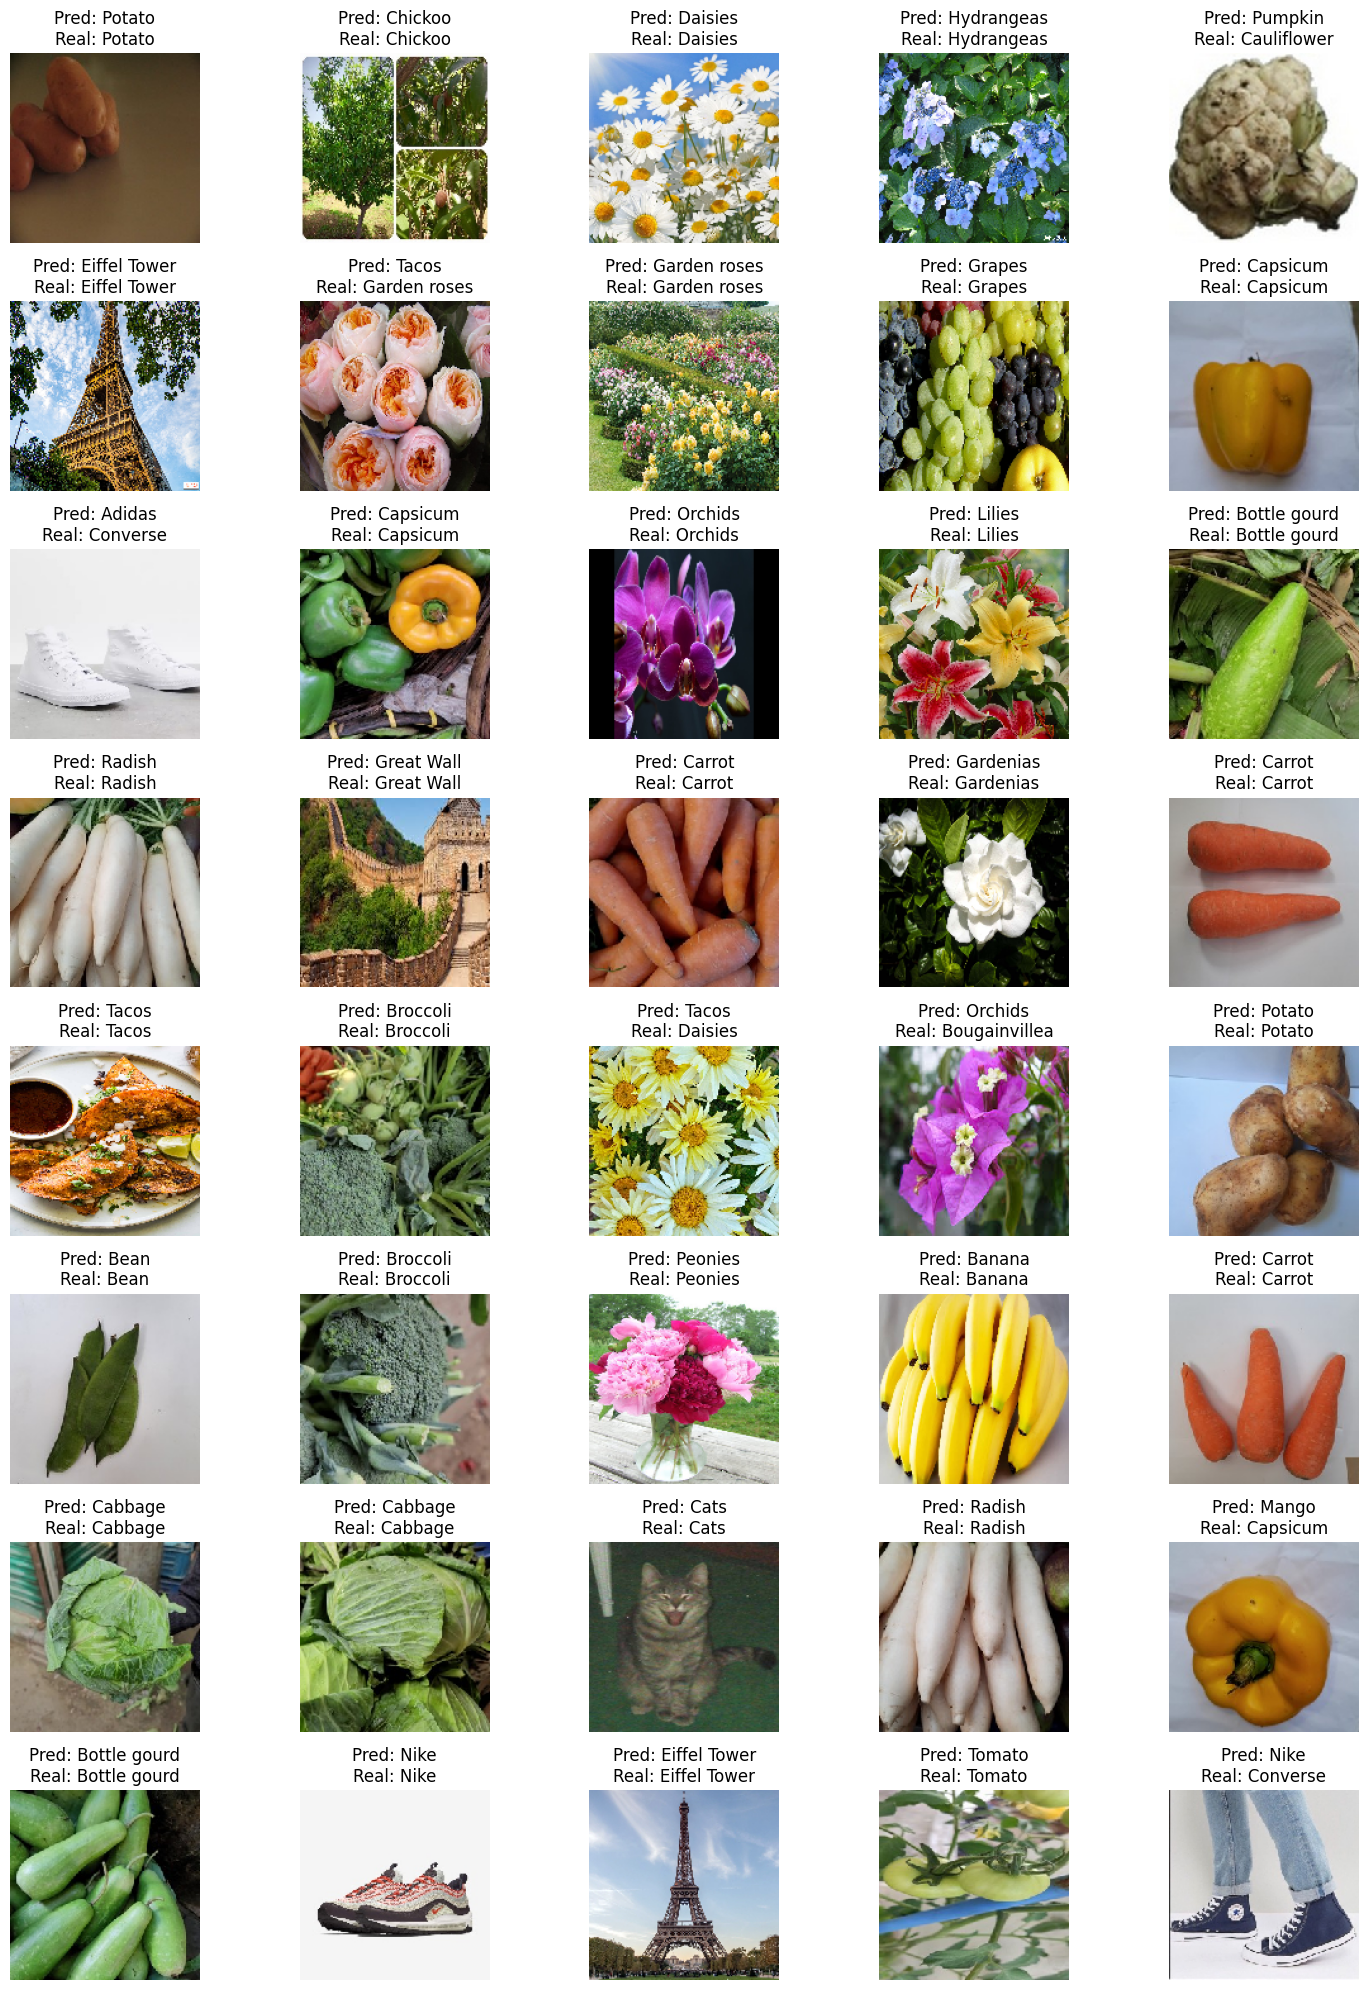

In [11]:
# Define image size (same as used in training)
# mix_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/mix"  # Folder where test images are stored

#Anita's
mix_dir = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/dataset/mix"# Folder where test images are stored

# Load class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Get 40 random images from mix
mix_images = os.listdir(mix_dir)
random.shuffle(mix_images)
mix_images = mix_images[:40]

# Plot predictions
fig, axes = plt.subplots(8, 5, figsize=(15, 20))
axes = axes.ravel()

for i, img_name in enumerate(mix_images):
    img_path = os.path.join(mix_dir, img_name)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Get real class from JSON (if available)
    real_label = class_mapping.get(img_name, "Unknown")

    # Show image with predictions
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {predicted_label}\nReal: {real_label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Adding Description to the predicted Classified classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


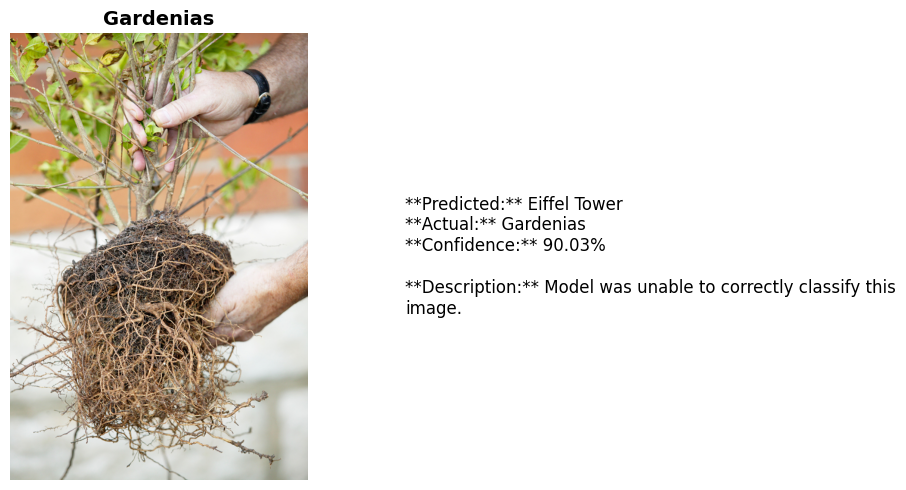

In [12]:
# csv_path = "/content/drive/MyDrive/Colab Notebooks/class_descriptions.csv"

# Anita'
csv_path = "/content/drive/MyDrive/Colab Notebooks - DLGA Project/class_descriptions.csv"

# Load class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Load descriptions from CSV
df = pd.read_csv(csv_path)
class_descriptions = dict(zip(df['Class'], df['Description']))  # Ensure correct column names

# Model input size
input_shape = model.input_shape
img_height, img_width = input_shape[1], input_shape[2]

# Select a random image
mix_images = os.listdir(mix_dir)
random_image = random.choice(mix_images)
img_path = os.path.join(mix_dir, random_image)

# Load and preprocess image
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Expand dims for prediction

# Set confidence threshold
CONFIDENCE_THRESHOLD = 0.5

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence_score = np.max(prediction) * 100  # Convert to percentage
predicted_label = class_labels[predicted_class]

# Get real class if available
real_label = class_mapping.get(random_image, "Unknown")

# Determine description or error message
if predicted_label == real_label:
    description = class_descriptions.get(predicted_label, "No description available")
else:
    description = "Model was unable to correctly classify this image."

# Create visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show image
ax[0].imshow(image.load_img(img_path))
ax[0].axis("off")
ax[0].set_title(real_label, fontsize=14, fontweight="bold")

# Show details (including confidence score)
details = (
    f"**Predicted:** {predicted_label}\n"
    f"**Actual:** {real_label}\n"
    f"**Confidence:** {confidence_score:.2f}%\n\n"
    f"**Description:** {description}"
)
ax[1].text(0.1, 0.5, details, fontsize=12, va="center", wrap=True)
ax[1].axis("off")

plt.tight_layout()
plt.show()